
# DINOv3 → Fastai Regression Head (Valence–Arousal)

This notebook shows how to **freeze a DINOv3 backbone** (from 🤗 Transformers) and train a **small regression head** in **fastai** for **valence–arousal (V-A)** prediction.

- Targets are expected in **FindingEmo** units: **V∈[-3,3]**, **A∈[0,6]**.  
- For training we map to a centered reference space: **v_ref = v/3**, **a_ref = (a−3)/3** → both in **[-1,1]**.  
- We compute **CCC** (Concordance Corr. Coefficient) per-dimension and the mean CCC.  
- Backbone remains **frozen**; only the tiny head trains.

> ⚠️ **Placeholders included:** You’ll find sections marked **TODO** where you should plug in your actual FindingEmo dataset (paths/splits). There’s also an optional **synthetic data** generator for a quick smoke test.


In [1]:
# --- Install latest libraries (uncomment if needed) ---
# %pip install -U torch torchvision torchaudio
# %pip install -U fastai transformers timm torchmetrics datasets
# %pip install -U accelerate
#
# If you're on Apple Silicon and want MPS acceleration, make sure your PyTorch build supports MPS.
# See: https://pytorch.org/get-started/locally/


In [2]:
from __future__ import annotations

import os, math, random, shutil, json
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional as F

# Fastai
from fastai.vision.all import *

# Transformers
from transformers import AutoImageProcessor, AutoModel

# Metrics
from torchmetrics.functional.regression import concordance_corrcoef as ccc_fn

# Device (prefers Apple MPS on M-series Macs)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.set_float32_matmul_precision("high")
device


device(type='mps')

In [3]:
# Load environment variables
from dotenv import load_dotenv

load_dotenv()

# Set HuggingFace token for authentication
if "HUGGINGFACE_TOKEN" in os.environ:
    from huggingface_hub import login

    login(token=os.environ["HUGGINGFACE_TOKEN"])

In [4]:
# =======================
# Config
# =======================
MODEL_NAME = "facebook/dinov3-vitb16-pretrain-lvd1689m"  # you can switch to vits16/vitsplus/vit7b16, etc.
IMAGE_SIZE = 224
BATCH_SIZE = 128
NUM_WORKERS = 12
EPOCHS = 10
LEARNING_RATE = 3e-3
ALPHA_CCC = 0.7  # weight for CCC in the mixed loss: loss = ALPHA_CCC*(1-mean_ccc) + (1-ALPHA_CCC)*MSE

# Data placeholders --- edit these for your FindingEmo setup
DATA_ROOT = Path("../data")  # FindingEmo dataset root
CSV_TRAIN = Path(
    "../data/train_clean_full.csv"
)  # CSV with columns: image_path,valence,arousal
CSV_VALID = Path("../data/valid_clean_full.csv")  # Validation split
CSV_TEST = Path("../data/test_clean_full.csv")  # Test split


In [5]:
# =======================
# Load DINOv3 processor + backbone
# =======================
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
backbone = AutoModel.from_pretrained(MODEL_NAME)

# Freeze backbone
for p in backbone.parameters():
    p.requires_grad = False

backbone = backbone.to(device)
backbone.eval()

# Infer feature dim for the pooled output
with torch.inference_mode():
    # Create a single dummy image tensor with processor's expected size
    dummy = torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE, dtype=torch.float32)
    out = backbone(pixel_values=dummy.to(device))
    feat_dim = None
    if hasattr(out, "pooler_output") and (out.pooler_output is not None):
        feat_dim = out.pooler_output.shape[-1]
    else:
        # Fallback: ViT CLS token (last_hidden_state[:, 0, :]) or spatial mean for ConvNext-like
        if hasattr(out, "last_hidden_state") and out.last_hidden_state.ndim == 3:
            feat_dim = out.last_hidden_state.shape[-1]
        elif hasattr(out, "last_hidden_state") and out.last_hidden_state.ndim == 4:
            feat_dim = out.last_hidden_state.shape[1]
        else:
            raise RuntimeError("Unable to determine DINOv3 feature dimension.")
feat_dim


768

In [6]:
# =======================
# Helpers: scaling & CCC
# =======================
def fe_to_ref(va: Tensor) -> Tensor:
    "Map FindingEmo V∈[-3,3], A∈[0,6] -> reference space [-1,1]"
    v = va[..., 0] / 3.0
    a = (va[..., 1] - 3.0) / 3.0
    return torch.stack([v, a], dim=-1)


def ref_to_fe(va_ref: Tensor) -> Tensor:
    "Inverse map: reference [-1,1] -> FindingEmo units"
    v = va_ref[..., 0] * 3.0
    a = va_ref[..., 1] * 3.0 + 3.0
    return torch.stack([v, a], dim=-1)


def ccc_mean(pred: Tensor, targ: Tensor) -> Tensor:
    "Mean CCC across V and A"
    # torchmetrics.functional returns per-output CCC for (N,2) inputs
    c = ccc_fn(pred, targ)  # shape: (2,)
    c = torch.nan_to_num(c, nan=0.0, posinf=0.0, neginf=0.0)
    return c.mean()


class CCCMixedLoss(nn.Module):
    "Mixed loss: alpha*(1-mean CCC) + (1-alpha)*MSE over the two dims"

    def __init__(self, alpha: float = 0.7):
        super().__init__()
        self.alpha = alpha

    def forward(self, pred: Tensor, targ: Tensor) -> Tensor:
        mse = F.mse_loss(pred, targ)
        ccc = ccc_mean(pred, targ)
        return self.alpha * (1.0 - ccc) + (1.0 - self.alpha) * mse


In [7]:
# =======================
# Load FindingEmo dataset
# =======================
import pandas as pd

df_train = pd.read_csv(CSV_TRAIN)
df_valid = pd.read_csv(CSV_VALID)
df_test = pd.read_csv(CSV_TEST)

# Show a peek
len(df_train), len(df_valid), len(df_test), df_train.head(2)


(12991,
 2808,
 2797,
                                                       image_path  valence  \
 0  ../data/Run_2/Indignant students hospital/sagada-students.jpg        1   
 1   ../data/Run_2/Frustrated toddlers shopping/0015a8db-1600.jpg        2   
 
    arousal  
 0        2  
 1        5  )

In [8]:
# =======================
# Fastai transform: apply HF processor per item
# =======================
class HFProcessorTransform(Transform):
    "Converts a PILImage to a TensorImage using the HF processor (resize/normalize)"

    def __init__(self, processor, image_size=IMAGE_SIZE):
        self.processor = processor
        self.image_size = image_size

    def encodes(self, img: PILImage):
        proc = self.processor(images=np.array(img), return_tensors="pt")
        # proc.pixel_values: [1, 3, H, W] (already resized & normalized as model expects)
        x = proc.pixel_values[0]
        return TensorImage(x)


# Label getter that reads FE units from df and maps to reference space [-1,1]
def get_y_ref(row):
    va = torch.tensor([row["valence"], row["arousal"]], dtype=torch.float32)
    return fe_to_ref(va)


item_tfms = [HFProcessorTransform(processor, IMAGE_SIZE)]
batch_tfms = []  # (you may add augmentations here if desired)


In [9]:
# =======================
# DataBlock + DataLoaders
# =======================
def df_to_dls(df_train, df_valid, bs=BATCH_SIZE, num_workers=NUM_WORKERS):
    dblock = DataBlock(
        blocks=(ImageBlock, RegressionBlock(n_out=2)),
        get_x=ColReader("image_path"),
        get_y=get_y_ref,
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )
    dls = dblock.dataloaders(
        df_train, valid_df=df_valid, bs=bs, num_workers=num_workers
    )
    return dls


dls = df_to_dls(df_train, df_valid)
dls.one_batch()[0].shape, dls.one_batch()[1].shape


(torch.Size([128, 3, 224, 224]), torch.Size([128, 2]))

In [10]:
# =======================
# Model: Frozen DINOv3 + tiny MLP head
# =======================
class DinoV3Regressor(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        feat_dim: int,
        hidden: int | None = None,
        p: float = 0.0,
    ):
        super().__init__()
        self.backbone = backbone
        if hidden and hidden > 0:
            self.head = nn.Sequential(
                nn.LayerNorm(feat_dim),
                nn.Dropout(p),
                nn.Linear(feat_dim, hidden),
                nn.GELU(),
                nn.Linear(hidden, 2),
            )
        else:
            self.head = nn.Sequential(
                nn.LayerNorm(feat_dim), nn.Dropout(p), nn.Linear(feat_dim, 2)
            )
        # Ensure backbone is frozen
        for p in self.backbone.parameters():
            p.requires_grad = False

    def forward(self, x: Tensor) -> Tensor:
        # x: pixel_values [B,3,H,W] already processor-normalized
        out = self.backbone(pixel_values=x)
        if hasattr(out, "pooler_output") and (out.pooler_output is not None):
            feats = out.pooler_output
        else:
            # CLS token (ViT) or spatial mean (ConvNeXt-like outputs)
            if hasattr(out, "last_hidden_state") and out.last_hidden_state.ndim == 3:
                feats = out.last_hidden_state[:, 0, :]
            else:
                # [B,C,H,W] -> global avg pool
                feats = out.last_hidden_state.mean(dim=(-1, -2))
        return self.head(feats)


model = DinoV3Regressor(backbone, feat_dim, hidden=512, p=0.1).to(device)
model


DinoV3Regressor(
  (backbone): DINOv3ViTModel(
    (embeddings): DINOv3ViTEmbeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (rope_embeddings): DINOv3ViTRopePositionEmbedding()
    (layer): ModuleList(
      (0-11): 12 x DINOv3ViTLayer(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attention): DINOv3ViTAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (o_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_scale1): DINOv3ViTLayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): DINOv3ViTMLP(
          (up_proj): Linear(in_features=768, out_features=3072, bias=True)
          (down_proj): Linear(in_features=30

In [11]:
# =======================
# Fastai metrics & loss
# =======================
def ccc_v(inp, targ):
    return ccc_fn(inp[:, 0], targ[:, 0])


def ccc_a(inp, targ):
    return ccc_fn(inp[:, 1], targ[:, 1])


def ccc_avg(inp, targ):
    return (ccc_v(inp, targ) + ccc_a(inp, targ)) / 2


loss_func = CCCMixedLoss(alpha=ALPHA_CCC)
metrics = [ccc_v, ccc_a, ccc_avg, mse]  # mse here is fastai's MSE metric


Suggested LRs: 0.00020892962347716094 0.005248074419796467


0.00020892962347716094

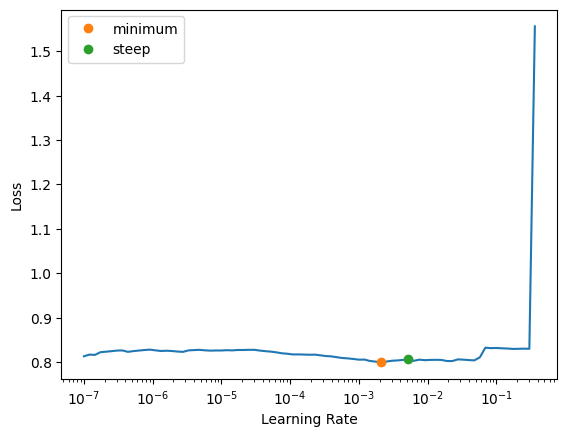

In [12]:
# =======================
# Create Learner & train
# =======================
learn = Learner(
    dls, model, loss_func=loss_func, metrics=metrics, cbs=[CSVLogger()]
).to_fp32()

# Choose optimizer and hyperparameters (FastAI will create Adam by default)
# You can override like this:
learn.opt_func = partial(Adam, wd=1e-2)
# Find a good learning rate
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print("Suggested LRs:", lr_min, lr_steep)
lr = float(lr_min)
lr

In [13]:
learn.fit_one_cycle(EPOCHS, lr)

epoch,train_loss,valid_loss,ccc_v,ccc_a,ccc_avg,mse,time
0,0.787101,0.746691,0.094796,0.055444,0.075120,0.330916,04:39
1,0.739781,0.696883,0.210624,0.110993,0.160809,0.364830,04:38
2,0.716606,0.694742,0.215486,0.120799,0.168142,0.374806,04:38
3,0.701643,0.683138,0.242734,0.109457,0.176096,0.354683,04:37
4,0.690012,0.683084,0.246579,0.122519,0.184549,0.374226,04:38
5,0.682162,0.694525,0.225561,0.115075,0.170318,0.379159,10:42
6,0.674272,0.678232,0.247853,0.126663,0.187258,0.364376,04:38
7,0.668888,0.683023,0.246041,0.115692,0.180866,0.365432,04:38
8,0.663666,0.679482,0.246397,0.121660,0.184029,0.361008,04:38
9,0.656414,0.680002,0.245686,0.120846,0.183266,0.360960,15:29


In [14]:
# =======================
# Evaluate on the test set
# =======================
test_dls = dls.test_dl(df_test)
test_metrics = learn.validate(dl=test_dls)
names = ["test_loss", "test_ccc_v", "test_ccc_a", "test_ccc_avg", "test_mse"]
# Handle None values in metrics
safe_metrics = [float(m) if m is not None else 0.0 for m in test_metrics]
dict(zip(names, safe_metrics))


{'test_loss': 0.0,
 'test_ccc_v': 0.0,
 'test_ccc_a': 0.0,
 'test_ccc_avg': 0.0,
 'test_mse': 0.0}

In [15]:
# =======================
# Save head weights (state_dict) and full model if desired
# =======================
SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(exist_ok=True)
head_path = SAVE_DIR / "dinov3_head.pth"
torch.save(model.head.state_dict(), head_path)

# Optionally export the whole fastai Learner
# learn.export(SAVE_DIR/"learner.pkl")

head_path, head_path.exists()


(Path('checkpoints/dinov3_head.pth'), True)

In [16]:
# =======================
# Inference helper (returns V,A in FE units)
# =======================
@torch.inference_mode()
def predict_image(img_path: str | Path):
    img = PILImage.create(img_path)
    x = HFProcessorTransform(processor)(img)  # [3,H,W] tensor
    x = x.unsqueeze(0).to(device)
    out_ref = model(x)  # [-1,1] space
    out_fe = ref_to_fe(out_ref.cpu())
    return out_fe.squeeze(0)


# Quick smoke test
sample_path = df_test.iloc[0]["image_path"]
predict_image(sample_path)


TensorImage([-2.7630,  1.2960])


## Notes & TODOs

- **Replace placeholders** (`DATA_ROOT`, `CSV_TRAIN`, `CSV_VALID`, `CSV_TEST`) and set `GENERATE_FAKE_DATA=False` to train on FindingEmo.  
- Your CSVs should have at least: `image_path,valence,arousal`.  
- We map labels to **[-1,1]** during training; CCC is computed in that same space. If you prefer, invert both preds & labels back to FindingEmo units before computing CCC—the value is invariant if both sides use the same affine map.  
- For Apple Silicon, make sure your Python + PyTorch build supports **MPS**. Training will default to CPU if MPS isn’t available.
- You can switch backbones by changing `MODEL_NAME` (e.g., `facebook/dinov3-vits16-pretrain-lvd1689m`). Larger models may need lower batch sizes.
